# Chronos

In [47]:
import pandas as pd
import numpy as np


In [48]:
# Import the data 
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df.set_index('Date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [49]:
train_df = load_and_prepare_data('../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../data/Final_data/test_df.csv')

train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)


In [50]:
# Import the data
df = load_and_prepare_data('../../data/Final_data/final_data.csv')

# Reset the index
df = df.reset_index()

In [51]:
import pandas as pd
import torch
from chronos import ChronosPipeline

# Load your data (assuming train_df and test_df are already defined)
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Extract the target and covariates
target_column = 'Day_ahead_price (€/MWh)'
covariate_columns = [col for col in train_df.columns if col not in ['Date', target_column]]

# For Chronos, target and covariates need to be converted to tensors
train_target = torch.tensor(train_df[target_column].values)
test_target = torch.tensor(test_df[target_column].values)

# Covariates should also be converted into tensors
train_covariates = torch.tensor(train_df[covariate_columns].values)
test_covariates = torch.tensor(test_df[covariate_columns].values)


In [53]:
# Initialize the Chronos pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",  # Choose the model size suitable for your resources
    device_map="mps",  # Use "cpu" if you are not using a GPU
    torch_dtype=torch.bfloat16  # Efficient datatype for GPUs
)

# Perform predictions with covariates included
forecast = pipeline.predict(
    context=train_target,  # Pass your target data
    prediction_length=30,  # Number of future steps to predict
    num_samples=100,  # Number of samples to generate
    #feat_dynamic_real=train_covariates.T  # Include covariates, needs to be transposed
)


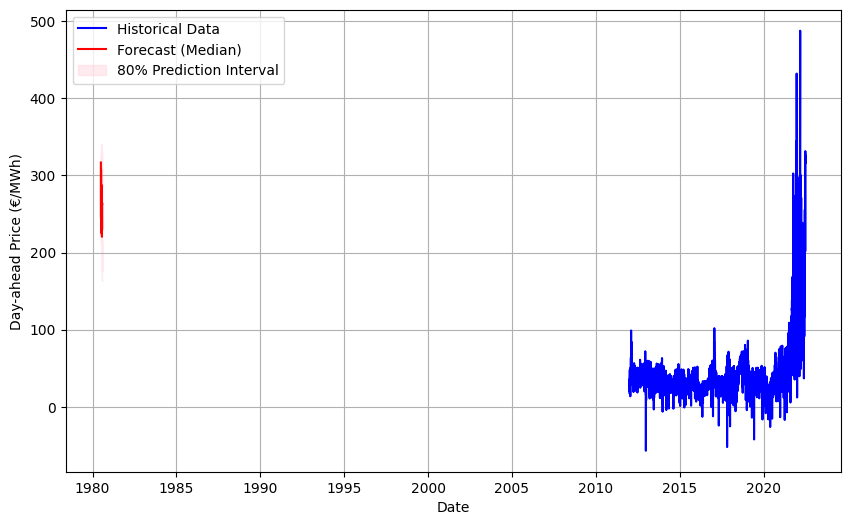

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Set up index for forecasted values
forecast_index = range(len(train_df), len(train_df) + 30)

# Get the 10th, 50th (median), and 90th percentiles of forecasted values
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

# Plot the historical data and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(train_df['Date'], train_df[target_column], label="Historical Data", color="blue")
plt.plot(forecast_index, median, label="Forecast (Median)", color="red")
plt.fill_between(forecast_index, low, high, color="pink", alpha=0.3, label="80% Prediction Interval")
plt.xlabel("Date")
plt.ylabel("Day-ahead Price (€/MWh)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
test_forecast = pipeline.predict(
    context=test_target,  # Test target data
    prediction_length=30,  # Number of days ahead you want to predict
    num_samples=100,  # Number of samples
    #feat_dynamic_real=test_covariates.T  # Test covariates
)
